In [1]:
import os
from PIL import Image

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
source_dir = '/kaggle/input/gesture-data2'


In [4]:
folders = os.listdir(os.path.join(source_dir,'mask_processed3'))
folders

['fingerCircle',
 'paper',
 'singleFingerBend',
 'rock',
 'multiFingerBend',
 'semiOpenPalm',
 'semiOpenFist',
 'scissors',
 'openPalm',
 'fingerSymbols']

In [5]:
loaded_image = {}

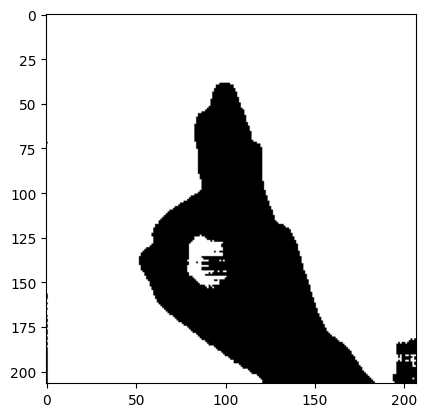

In [6]:
img2 = cv2.imread('/kaggle/input/gesture-data/mask_processed3/fingerCircle/masks/fingerCircle0_mask.png',cv2.IMREAD_COLOR_RGB)
plt.imshow(img2)

In [7]:
img2.shape

(207, 207, 3)

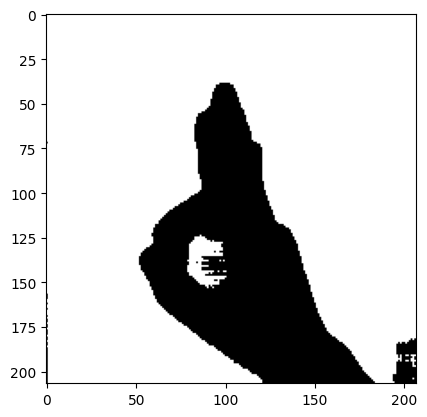

In [8]:
img2 = cv2.imread('/kaggle/input/gesture-data/mask_processed3/fingerCircle/masks/fingerCircle0_mask.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img2, cmap='gray')  # Ensure it shows properly


In [9]:
img2.shape

(207, 207)

In [10]:
def preprocess_semantic_segmentation(mask):
    """
    Prepares the semantic segmentation mask:
    - Converts grayscale mask into categorical values.
    - Expands dimensions to match RGB channels.
    """
    mask = mask.astype(np.float32)  # Ensure it's float
    mask = np.expand_dims(mask, axis=-1)  # Convert (512, 512) → (512, 512, 1)
    return mask


In [11]:
img = preprocess_semantic_segmentation(img2)
img.shape

(207, 207, 1)

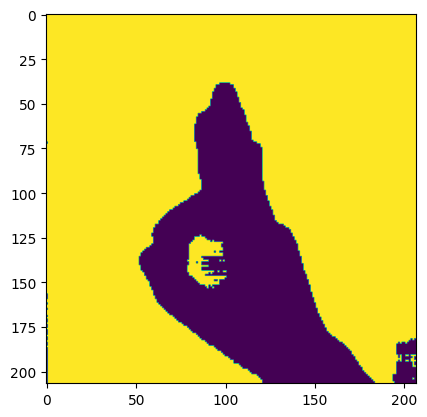

In [12]:
plt.imshow(img)

In [13]:
def combine_data(image_path, mask_path):
    """
    Combines object detection and semantic segmentation into one state tensor.
    """

    image = cv2.imread(image_path, cv2.IMREAD_COLOR_RGB)
    mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = preprocess_semantic_segmentation(mask)

    # Merge into (512, 512, 4) → (RGB + Segmentation)
    state_representation = np.concatenate([image, mask], axis=-1)

    return state_representation

In [14]:
def get_image_and_mask_paths(base_dir):

    count = 0
    image_dir = os.path.join(base_dir, 'images')
    mask_dir = os.path.join(base_dir, 'masks')

    image_filenames = os.listdir(image_dir)
    image_mask_pairs = []

    for img_name in image_filenames:
        base_name, ext = os.path.splitext(img_name)
        mask_name = base_name + '_mask' + ext

        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)

        if os.path.exists(mask_path):
            image_mask_pairs.append((img_path, mask_path))
        else:
            print(f"Warning: Mask not found for image {img_name}")
            count += 1
    print(count)

    return image_mask_pairs


In [15]:
os.listdir(os.path.join(source_dir,'mask_processed2'))

['fingerCircle',
 'paper',
 'singleFingerBend',
 'rock',
 'multiFingerBend',
 'semiOpenPalm',
 'semiOpenFist',
 'scissors',
 'openPalm',
 'fingerSymbols']

In [16]:
def load_image(source_dir,dict_store,folder):
    dict_path = {}
    folder_path = os.path.join(source_dir,folder)
    for label in os.listdir(folder_path):
        path = os.path.join(source_dir,folder,label)
        list_path = get_image_and_mask_paths(path)
        dict_path[label] = list_path

    for label in os.listdir(folder_path):
        path_pairs = dict_path[label]
        for path_pair in path_pairs:
            img = combine_data(path_pair[0],path_pair[1])
            dict_store[label].append(img)

    return dict_store
    
    
    

In [17]:
dict_store = {}
folder_path = os.path.join(source_dir,'mask_processed2')
for label in os.listdir(folder_path):
    dict_store[label] = []

In [18]:
print(dict_store.keys())

dict_keys(['fingerCircle', 'paper', 'singleFingerBend', 'rock', 'multiFingerBend', 'semiOpenPalm', 'semiOpenFist', 'scissors', 'openPalm', 'fingerSymbols'])


In [20]:
dict_store = load_image(source_dir,dict_store,'mask_processed2')

0
0
0
0
0
0
0
0
0
0


In [21]:
dict_store = load_image(source_dir,dict_store,'mask_processed3')

0
0
0
0
0
0
0
0
0
0


In [22]:
import numpy as np

def normalize_images(images):

    images = images.astype(np.float32) / 255.0
    return images


In [23]:
for label in dict_store.keys():
    for i,image in enumerate(dict_store[label]):
        dict_store[label][i] = normalize_images(image)

In [54]:
keys_to_remove = ['multiFingerBend','semiOpenPalm', 'semiOpenFist','openPalm','fingerSymbols']
for key in keys_to_remove:
    dict_store.pop(key, None)  # 'None' avoids KeyError if key doesn't exist


In [55]:
import random

def trim_list_randomly(my_list, target_length=250):
    if len(my_list) > target_length:
        my_list = random.sample(my_list, target_length)
    return my_list


In [56]:
for label in dict_store.keys():
    trimmed_data = trim_list_randomly(dict_store[label])
    dict_store[label] = trimmed_data



In [57]:
for label in dict_store.keys():
    print(len(dict_store[label]),label)

250 fingerCircle
250 paper
250 singleFingerBend
250 rock
250 scissors


In [58]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def encode_labels_and_flatten(dict_store):
    """
    From dict_store {label: [images]}, flatten images and labels into arrays,
    then encode string labels to integers.
    
    Args:
        dict_store (dict): keys = string labels, values = list or array of images
    
    Returns:
        tuple: (images_array, encoded_labels_array, label_encoder)
    """
    images = []
    labels = []
    
    for label, img_list in dict_store.items():
        images.extend(img_list)
        labels.extend([label] * len(img_list))
    
    images = np.array(images)
    labels = np.array(labels)
    
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    
    return images, encoded_labels, le


def split_data(images, encoded_labels, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, random_state=42):
    """
    Split images and encoded labels into train, validation, and test sets.
    Uses stratify to maintain class distribution.
    
    Args:
        images (np.ndarray): Array of images, shape (N, H, W, C)
        encoded_labels (np.ndarray): Array of integer encoded labels, shape (N,)
        train_ratio (float): Fraction of training data
        val_ratio (float): Fraction of validation data
        test_ratio (float): Fraction of test data
        random_state (int): Random seed
    
    Returns:
        tuple: (X_train, y_train), (X_val, y_val), (X_test, y_test)
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"
    
    X_train, X_temp, y_train, y_temp = train_test_split(
        images, encoded_labels, test_size=(1 - train_ratio), random_state=random_state, stratify=encoded_labels)
    
    val_fraction = val_ratio / (val_ratio + test_ratio)
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=(1 - val_fraction), random_state=random_state, stratify=y_temp)
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


In [59]:
images, encoded_labels, _ = encode_labels_and_flatten(dict_store)

In [60]:
images.shape

(1250, 207, 207, 4)

In [61]:
encoded_labels.shape

(1250,)

In [62]:
train, val, test = split_data(images,encoded_labels)

In [63]:
output = [len(train[0]),len(val[0]),len(test[0])]
output

[874, 250, 126]

In [64]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Transformer Encoder Block
def transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    # Layer Normalization
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    # Multi-Head Attention
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Add()([x, inputs])  # Residual connection

    # Feed-forward part
    x2 = layers.LayerNormalization(epsilon=1e-6)(x)
    x2 = layers.Dense(ff_dim, activation='relu')(x2)
    x2 = layers.Dropout(dropout)(x2)
    x2 = layers.Dense(inputs.shape[-1])(x2)
    return layers.Add()([x, x2])  # Residual connection

# Main model
def build_hybrid_model(input_shape=(207, 207, 4), num_classes=5):  # Update num_classes as needed
    inputs = layers.Input(shape=input_shape)

    # CNN Block
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)  # 101x103x64

    # Patch Embedding for Transformer
    patch_size = 4
    x = layers.Conv2D(128, kernel_size=patch_size, strides=patch_size, padding='valid')(x)  # downsample
    x = layers.Reshape((-1, 128))(x)  # (batch, num_patches, embedding_dim)

    # Transformer Encoder Blocks
    for _ in range(2):
        x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128)

    # Classification Head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, x)

# Example usage
model = build_hybrid_model(input_shape=(207, 207, 4), num_classes=5)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 207, 207, 4)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 207, 207, 32)   │          1,184 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 207, 207, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 207, 207, 64)   │         18,496 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 207, 207, 64)   │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 103, 103, 64)   │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 25, 25, 128)    │        131,200 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 625, 128)       │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 625, 128)       │            256 │ reshape_1[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 625, 128)       │        131,968 │ layer_normalization_4… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 625, 128)       │              0 │ multi_head_attention_… │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 625, 128)       │            256 │ add_4[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 625, 128)       │         16,512 │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 625, 128)       │              0 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 625, 128)       │         16,512 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)          

 Total params: 499,429 (1.91 MB)

 Trainable params: 499,237 (1.90 MB)

 Non-trainable params: 192 (768.00 B)

In [65]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use categorical if labels are one-hot
    metrics=['accuracy']
)


In [66]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



checkpoint = ModelCheckpoint(
    'best_model.h5',       # Change to .keras if preferred
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


In [67]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,  # ← try increasing this
    restore_best_weights=True
)

In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Fit the generator (needed if using featurewise normalization, not always required)
datagen.fit(train[0])

In [69]:
history = model.fit(
    datagen.flow(train[0], train[1], batch_size=32),
    validation_data=(val[0], val[1]),
    epochs=30,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.4362 - loss: 1.3150
Epoch 1: val_loss improved from inf to 2.08951, saving model to best_model.h5
28/28 ━━━━━━━━━━━━━━━━━━━━ 39s 809ms/step - accuracy: 0.4373 - loss: 1.3117 - val_accuracy: 0.2000 - val_loss: 2.0895
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.4945 - loss: 0.9947
Epoch 2: val_loss improved from 2.08951 to 1.71704, saving model to best_model.h5
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 386ms/step - accuracy: 0.4966 - loss: 0.9919 - val_accuracy: 0.2640 - val_loss: 1.7170
Epoch 3/30
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.5962 - loss: 0.7958
Epoch 3: val_loss did not improve from 1.71704
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 360ms/step - accuracy: 0.5980 - loss: 0.7944 - val_accuracy: 0.3200 - val_loss: 2.0203
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7049 - loss: 0.6962
Epoch 4: val_loss did not improve from 1.71704
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 376ms/step - accu

In [70]:
history = model.fit(
    train[0], train[1],
    validation_data=(val[0], val[1]),
    epochs=30,
    batch_size=32,
    callbacks=[checkpoint]
)


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.6253 - loss: 0.7806
Epoch 1: val_loss did not improve from 1.71704
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.6247 - loss: 0.7820 - val_accuracy: 0.1760 - val_loss: 1.8538
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7104 - loss: 0.6937
Epoch 2: val_loss did not improve from 1.71704
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.7098 - loss: 0.6943 - val_accuracy: 0.3480 - val_loss: 1.8934
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.6604 - loss: 0.7637
Epoch 3: val_loss did not improve from 1.71704
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.6609 - loss: 0.7629 - val_accuracy: 0.2000 - val_loss: 5.9873
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.6818 - loss: 0.7118
Epoch 4: val_loss did not improve from 1.71704
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.6820 - loss: 0.7103 - val_accuracy: 0.2000 - val_loss: 3.9667


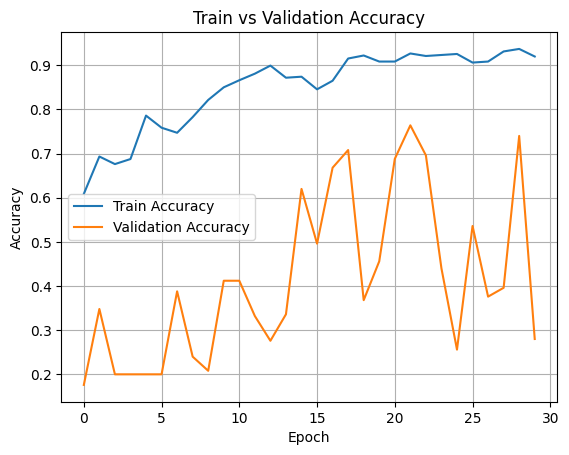

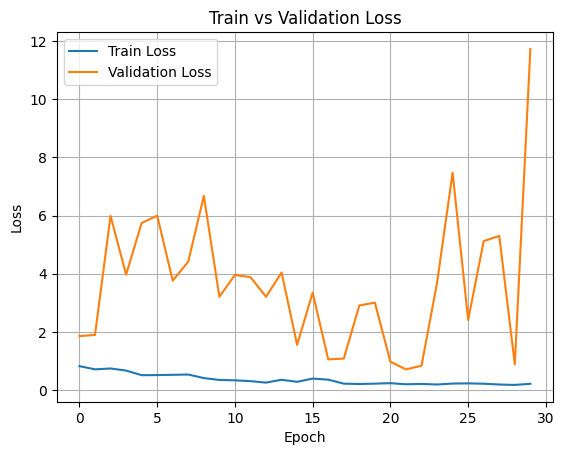

In [71]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [72]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')  # or .keras


Input (202×207×4)
↓
Conv2D + BN + ReLU × 2
↓
MaxPooling
↓
Conv2D + BN + ReLU × 2
↓
Patch Embedding (Flatten into tokens)
↓
Transformer Encoder (2–4 layers)
↓
Global Average Pooling
↓
Fully Connected (Softmax / Sigmoid)


In [73]:
import matplotlib.pyplot as plt

def plot_accuracy_loss(history):
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


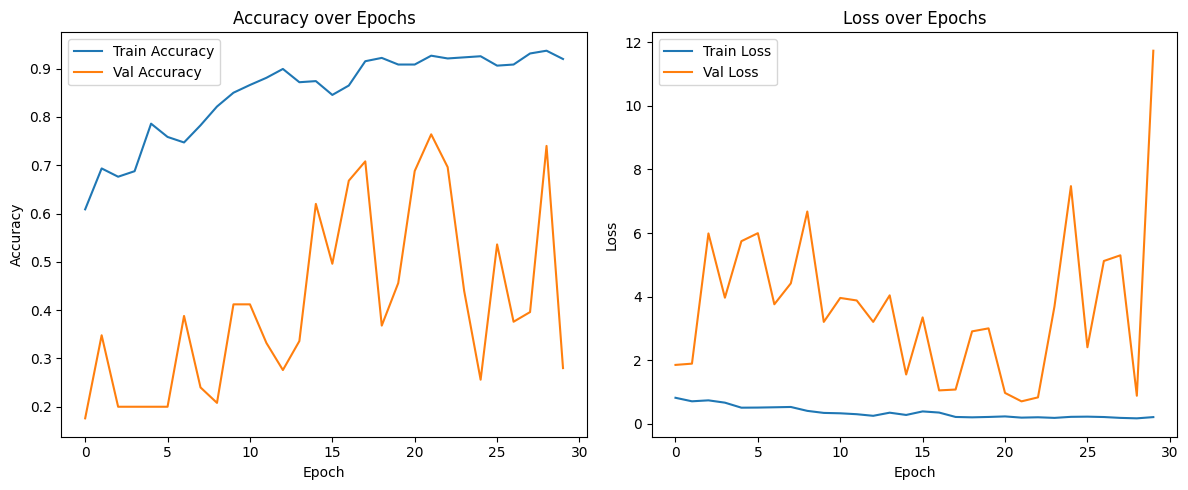

In [74]:
plot_accuracy_loss(history.history)


In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()


In [76]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns

def plot_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])
    
    df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6))
    plt.title("Precision, Recall, and F1-Score per Class")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.show()


In [77]:
import numpy as np

# Predict probabilities
y_pred_proba = model.predict(test[0])

# Convert to class index
y_pred = np.argmax(y_pred_proba, axis=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step 


In [78]:
class_names = dict_store.keys()

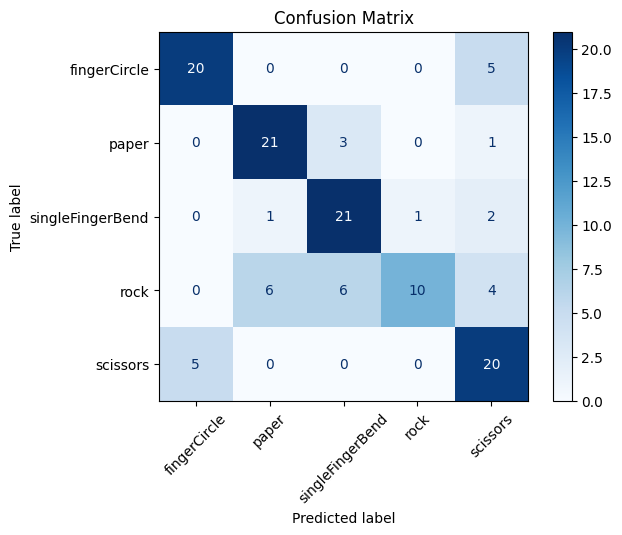

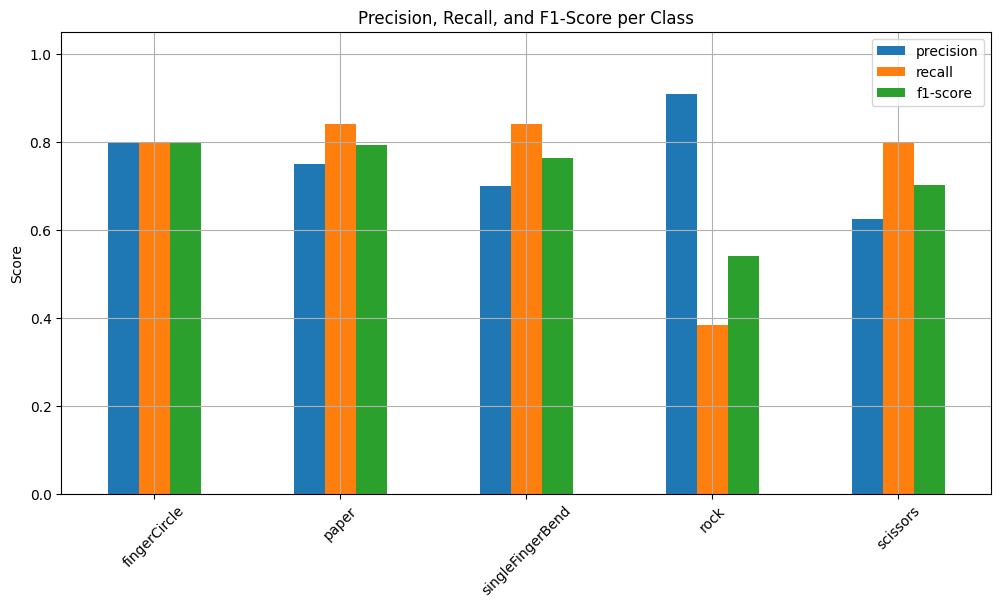

In [79]:
plot_confusion_matrix(test[1], y_pred, class_names)
plot_classification_report(test[1], y_pred, class_names)


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.2465 - loss: 2.6390 - val_accuracy: 0.0800 - val_loss: 1.7257
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step - accuracy: 0.3912 - loss: 1.2080 - val_accuracy: 0.2000 - val_loss: 1.5816
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step - accuracy: 0.4193 - loss: 1.1054 - val_accuracy: 0.2000 - val_loss: 2.1783
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 302ms/step - accuracy: 0.4262 - loss: 1.0727 - val_accuracy: 0.2040 - val_loss: 1.8083
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 305ms/step - accuracy: 0.5299 - loss: 0.9337 - val_accuracy: 0.1960 - val_loss: 3.6088
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 302ms/step - accuracy: 0.5053 - loss: 1.0279 - val_accuracy: 0.3600 - val_loss: 1.5739
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 297ms/step - accuracy: 0.5080 - loss: 0.9001 - val_accuracy: 0.2560 - val_loss: 5.5900
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 293ms/step - accuracy: 0.5432 - loss: 0.9108 - val_accuracy: 0.27

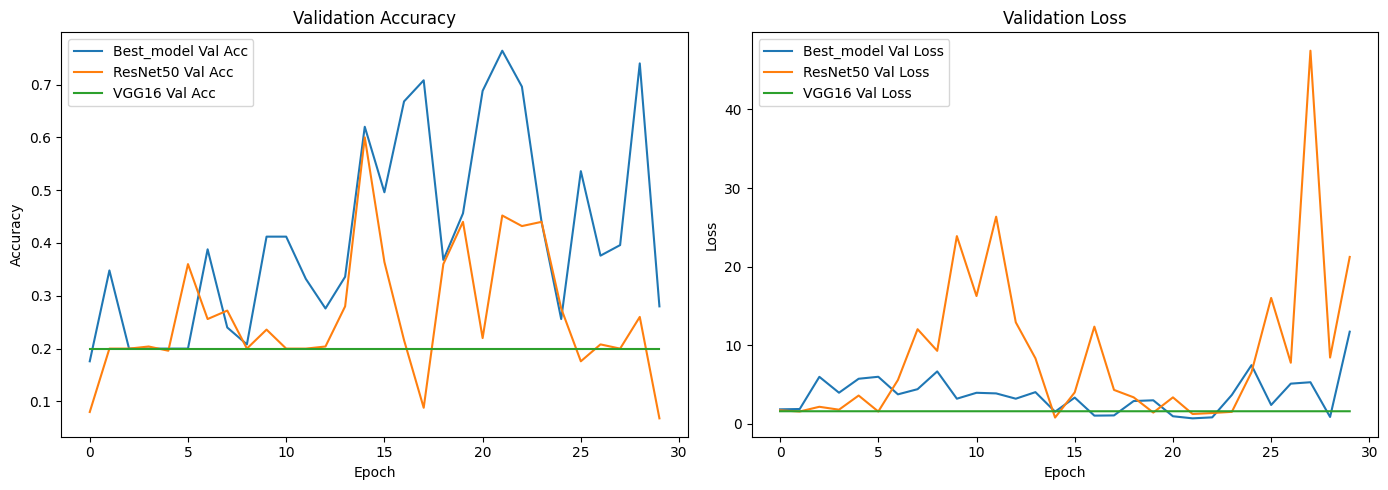

In [82]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Assumed: your_model, num_classes already defined
# Assumed: x_train, y_train, x_val, y_val, x_test, y_test already loaded
num_classes = 5
x_train, y_train, x_val, y_val, x_test, y_test = train[0], train[1], val[0], val[1], test[0], test[1]

# Helper function to build classification model
def build_model(base_model):
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs=base_model.input, outputs=output)

# Input shape
input_shape = (207, 207, 4)

# Build ResNet and VGG
resnet_base = ResNet50(weights=None, include_top=False, input_shape=input_shape)
vgg_base = VGG16(weights=None, include_top=False, input_shape=input_shape)

resnet_model = build_model(resnet_base)
vgg_model = build_model(vgg_base)

# Compile all models
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# your_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train models
# history_your = your_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)
history_resnet = resnet_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=32)
history_vgg = vgg_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30, batch_size=32)

# Evaluate
your_test_loss, your_test_acc = model.evaluate(x_test, y_test)
resnet_test_loss, resnet_test_acc = resnet_model.evaluate(x_test, y_test)
vgg_test_loss, vgg_test_acc = vgg_model.evaluate(x_test, y_test)

# Print comparison
print("✅ Test Accuracy Comparison:")
print(f"Your Model      : {your_test_acc:.4f}")
print(f"ResNet50 (scratch): {resnet_test_acc:.4f}")
print(f"VGG16 (scratch)  : {vgg_test_acc:.4f}")

# Plot histories
def plot_history(histories, labels):
    plt.figure(figsize=(14,5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    for hist, label in zip(histories, labels):
        plt.plot(hist.history['val_accuracy'], label=f'{label} Val Acc')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for hist, label in zip(histories, labels):
        plt.plot(hist.history['val_loss'], label=f'{label} Val Loss')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history([history, history_resnet, history_vgg], ['Best_model', 'ResNet50', 'VGG16'])
